### sampling probability distributions

In [76]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

### grain size and melt fraction

log-uniform grain size

Text(0.5, 0, 'log10(grain size)')

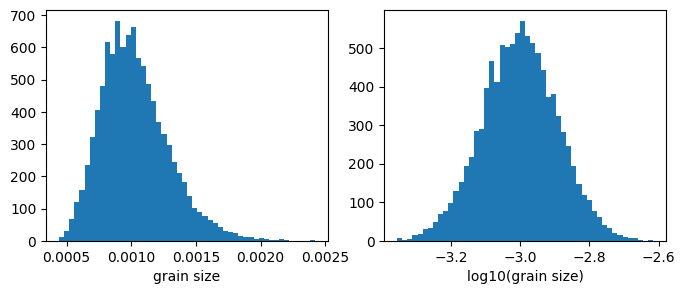

In [77]:
grain_size_dist = stats.lognorm(0.25, scale=0.001)

samples = grain_size_dist.rvs(size=10000)

f, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,3))
axs[0].hist(samples, histtype="stepfilled", bins = 50)
axs[0].set_xlabel("grain size")
axs[1].hist(np.log10(samples), histtype="stepfilled", bins = 50)
axs[1].set_xlabel("log10(grain size)")

Text(0.5, 0, 'log10(melt fraction)')

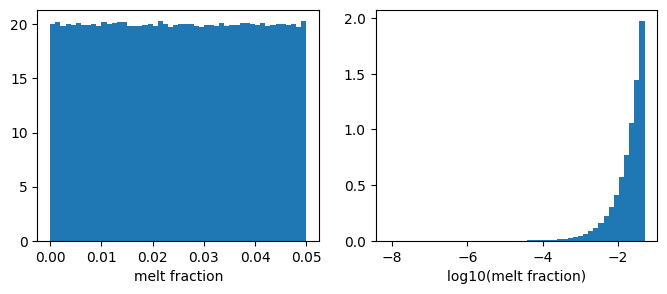

In [78]:
min_melt_fraction = 0
max_melt_fraction = 0.05 

melt_fraction_dist = stats.uniform(min_melt_fraction, max_melt_fraction)

samples = melt_fraction_dist.rvs(size=1000000)

f, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,3))
axs[0].hist(samples, histtype="stepfilled", density=True, bins = 50)
axs[0].set_xlabel("melt fraction")
axs[1].hist(np.log10(samples), histtype="stepfilled", density=True, bins = 50)
axs[1].set_xlabel("log10(melt fraction)")

## temperature

Text(0.5, 0, 'T')

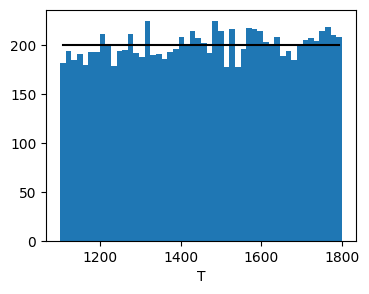

In [79]:
mean_T = 1400
sig_T = 100

T_dist_C = stats.uniform(1100, 700)

# T_dist_C = stats.norm(mean_T, sig_T)

samples = T_dist_C.rvs(size=10000)

f, axs = plt.subplots(1, figsize=(4,3))
counts, bin_edges, ignored = axs.hist(samples, histtype="stepfilled", density=False, bins = 50)
x = (bin_edges[1:] + bin_edges[0:-1])/2.
xpdf = T_dist_C.pdf(x)
pdf_scaled = xpdf * (counts.sum() * np.diff(bin_edges))
axs.plot(x,pdf_scaled ,'k')
axs.set_xlabel("T")

## Observation:

Take the Q and Vs values for the Basin and Range from Havlin et. al 2021 (which are from Dalton & Ekstrom 2008, Shen and Ritzwoller 2016), which are at 3 GPa

In [80]:
Q = 54.  # from B&R
std_Q = 10.
Vs = 4.12 * 1e3 # from B&R
Vs_std = 0.05 * 1e3
(Q, Vs)

(54.0, 4120.0)

## Predicting Values 

We'll use a pyVBRc interpolator to predict Vs, Q from T, phi, grain size. The following `.mat` file can be generated using `vbr_bayes_generate_vbr.m` in this directory. It differs slightly from that used by Havlin et al., 2021 in that it is calculated for 2 frequencies and we will proceed with our bayes inference using only a single frequency. Let's load the `.mat` file first and initialize interpolators for `Vs` and `Q`:

In [81]:
from pyVBRc.vbrc_structure import VBRCstruct

In [82]:
vbr = VBRCstruct('./VBRc_sample_LUT.mat', lut_dimensions=["T_K", "phi", "dg_um"])
vbr.input.SV.f

array([0.01, 0.1 ])

In [83]:
V_interp = vbr.interpolator(('anelastic', 'andrade_psp', 'V'), 0, log_vars=['dg_um'])
Q_interp = vbr.interpolator(('anelastic', 'andrade_psp', 'Q'), 0, log_vars=['dg_um'])
vbr.lut_dimensions

['T_K', 'phi', 'dg_um']

## Likelihood

The next thing we need is a way to calculate the likelihood, P(T, d, phi | Vs, Q). 

For a given T, phi, dg_m, we need to calculate predicted values and then calculate the probability that those predicted values are in the distribution of observed values. Following Havlin et al., 2021 we treat our observations as normal distributions, in which case we can construct a function to take a given T, phi, grain size and return a likelihood:

In [84]:
def Q_likeli(Q_pred):
    return 1./(std_Q * np.sqrt(2*np.pi)) * np.exp( - 0.5 * ((Q_pred - Q)/std_Q)**2)

def Vs_likeli(V_pred):
    return 1./(Vs_std * np.sqrt(2*np.pi)) * np.exp( - 0.5 * ((V_pred - Vs)/Vs_std)**2)

def likelihood(T, phi, dg_m):
    
    dg_um = dg_m * 1e6
    Vs_pred = V_interp((T+273, phi, np.log10(dg_um)))
    Q_pred = Q_interp((T+273, phi, np.log10(dg_um)))
    
    P_Q = Q_likeli(Q_pred)
    P_Vs = Vs_likeli(Vs_pred)
    return P_Q * P_Vs
        

This function works with single values:

In [85]:
likelihood(1200, 0.001, 0.004)

1.5108428066497006e-22

or with 1D arrays of values:

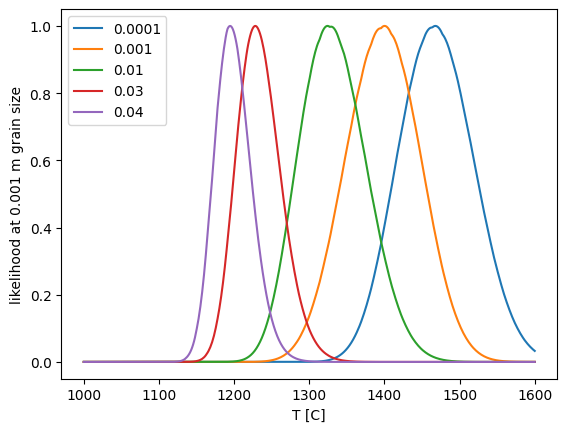

In [86]:
Ttest = np.linspace(1000, 1600, 500)  # degree C
dgtest = np.full(Ttest.shape, 0.001)
for phival in [0.0001, 0.001, 0.01, 0.03, 0.04]:    
    phitest = np.full(Ttest.shape,phival)    
    L = likelihood(Ttest, phitest, dgtest)
    plt.plot(Ttest, L/L.max(), label=f"{phival}")
plt.xlabel("T [C]")
plt.ylabel("likelihood at 0.001 m grain size")
plt.legend()

To use with multi-dimensional grids, we'll need to flatten and then un-flatten:

In [87]:
Ttest = np.linspace(1100, 1600, 45)  # degree C
philtest = np.linspace(0, 0.05, 50) 
dgtest = np.logspace(-4, -2, 35)

Tg, philt, dgg = np.meshgrid(Ttest, philtest, dgtest, indexing='ij')

P = likelihood(Tg.flatten(), philt.flatten(), dgg.flatten())
P = P.reshape(Tg.shape)
P.shape

(45, 50, 35)

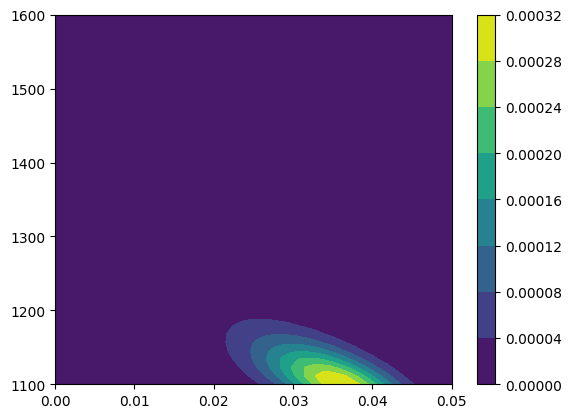

In [88]:
plt.contourf(philtest, Ttest, P[:,:, 0])
plt.colorbar()

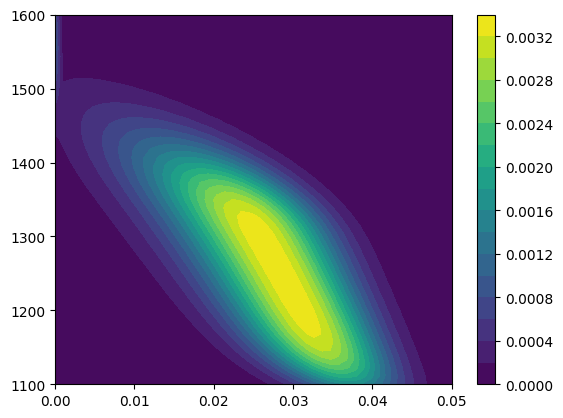

In [103]:
plt.contourf(philtest, Ttest, P.sum(axis=2), levels=20)
plt.colorbar()

## Pure bayes inference

The above plots are just likelihoods. For a full bayes inference, we want to multiply by our prior distributions. So let's extract our prior model pdf's from our scipy.stats distributiosn:

In [63]:
P_T = T_dist_C.pdf(Tg)
P_phi = melt_fraction_dist.pdf(philt)
P_dgg = grain_size_dist.pdf(dgg)
P_T.shape

(45, 50, 35)

and calculation our final posterior:

In [64]:
Posterior = P * P_T * P_phi * P_dgg

we'll want to plot our marginal probabilities by summing over the axis not plotted:

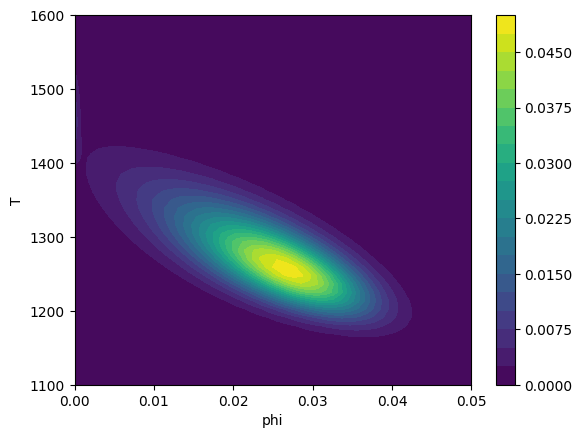

In [89]:
plt.contourf(philtest, Ttest, Posterior.sum(axis=2), levels=20)
plt.xlabel("phi")
plt.ylabel("T")
plt.colorbar()

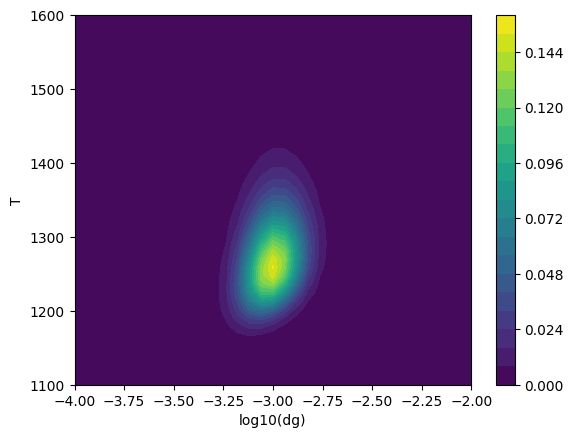

In [90]:
plt.contourf(np.log10(dgtest), Ttest, Posterior.sum(axis=1), levels=20)
plt.xlabel("log10(dg)")
plt.ylabel("T")
plt.colorbar()

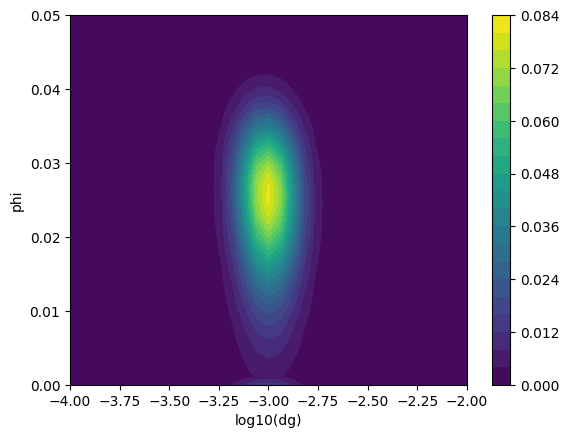

In [91]:
plt.contourf(np.log10(dgtest), philtest, Posterior.sum(axis=0), levels=20)
plt.xlabel("log10(dg)")
plt.ylabel("phi")
plt.colorbar()

Note that there are small differences from Havlin et al., 2021 figure 10 because we are doing this at a single frequency rather than averaging over frequencies. 

## temperature: a normal distribution

Text(0.5, 0, 'T')

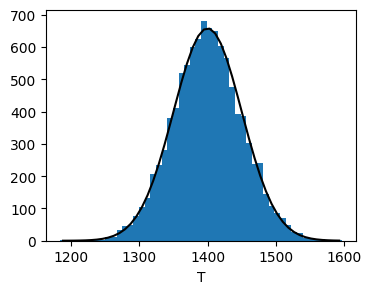

In [98]:
mean_T = 1400
sig_T = 50

T_dist_C = stats.norm(mean_T, sig_T)

samples = T_dist_C.rvs(size=10000)

f, axs = plt.subplots(1, figsize=(4,3))
counts, bin_edges, ignored = axs.hist(samples, histtype="stepfilled", density=False, bins = 50)
x = (bin_edges[1:] + bin_edges[0:-1])/2.
xpdf = T_dist_C.pdf(x)
pdf_scaled = xpdf * (counts.sum() * np.diff(bin_edges))
axs.plot(x,pdf_scaled ,'k')
axs.set_xlabel("T")

In [99]:
P_T = T_dist_C.pdf(Tg)
P_phi = melt_fraction_dist.pdf(philt)
P_dgg = grain_size_dist.pdf(dgg)
Posterior = P * P_T * P_phi * P_dgg

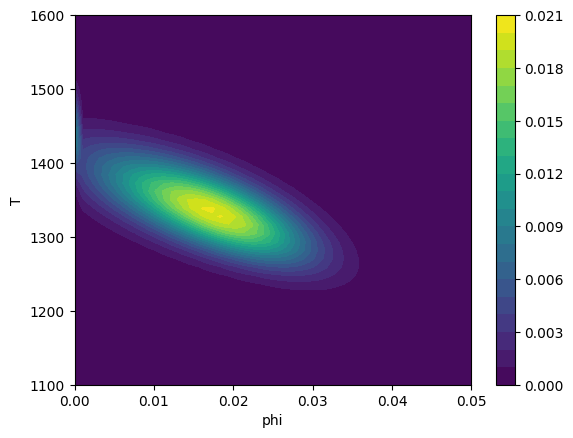

In [100]:
plt.contourf(philtest, Ttest, Posterior.sum(axis=2), levels=20)
plt.xlabel("phi")
plt.ylabel("T")
plt.colorbar()